# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [17]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
import typing

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

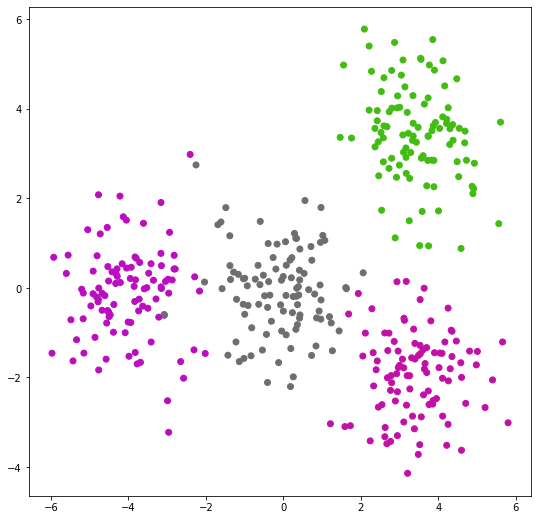

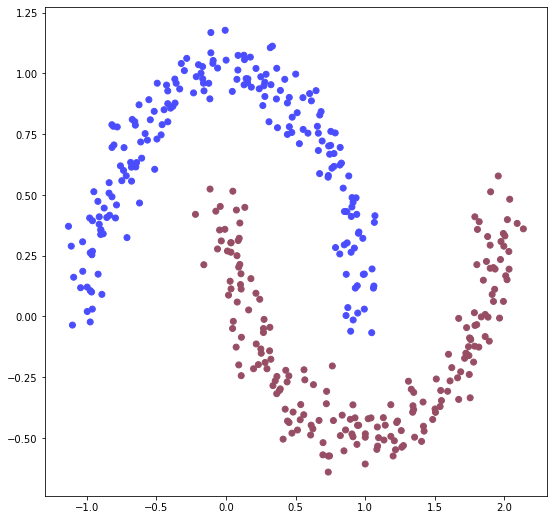

In [16]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [40]:
class KMeans:

    def __init__(self, n_clusters: int, init: str = 'random', max_iter: int = 300):
        assert n_clusters > 0
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None

    def sample_init(self, xs: np.ndarray):
        self.centroids = xs.copy()
        np.random.shuffle(self.centroids)
        self.centroids = self.centroids[:self.n_clusters]

    def random_init(self, shape: typing.Tuple):
        self.centroids = np.random.random(shape)[:self.n_clusters]

    def k_means_plus_plus_init(self, xs: np.ndarray):
        self.centroids = [xs[np.random.randint(0, xs.shape[0])]]
        for i in range(1, self.n_clusters):
            kd_tree = KDTree(np.array(self.centroids))
            dists, _ = kd_tree.query(X=xs)
            dists = np.array([d ** 2 for d in dists[:, 0]])

            next_d = np.random.uniform(0, dists.sum())
            next_c = 0
            cur_sum_d = 0
            while next_c < xs.shape[0] and cur_sum_d + dists[next_c] < next_d:
                cur_sum_d += dists[next_c]
                next_c += 1

            self.centroids.append(xs[next_c])

        self.centroids = np.array(self.centroids)

    def fit(self, xs: np.ndarray, y=None):
        if self.init == 'random':
            self.random_init(xs.shape)
        elif self.init == 'sample':
            self.sample_init(xs)
        elif self.init == 'k-means++':
            self.k_means_plus_plus_init(xs)
        else:
            raise Exception(f'Unrecognised init type: {self.init}')

    def predict(self, xs: np.ndarray):
        kd_tree = KDTree(self.centroids)
        _, i = kd_tree.query(xs)
        result = i[:, 0]
        if np.unique(result).shape[0] != self.n_clusters:
            return self.predict(xs)
        else:
            return result


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

### Random Init

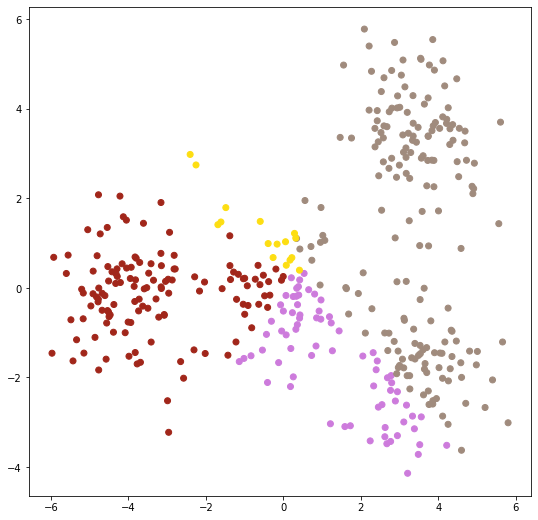

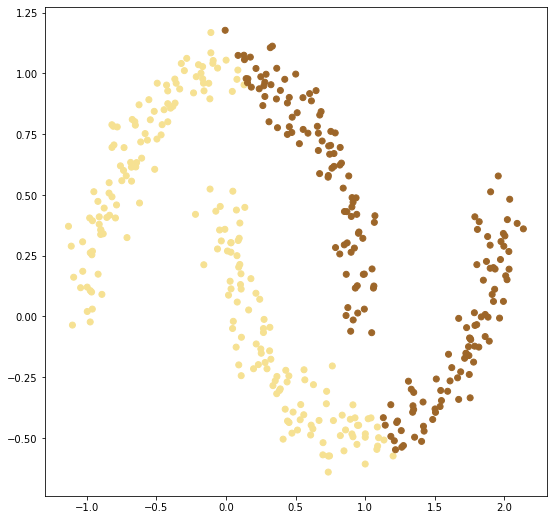

In [44]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Sample Init

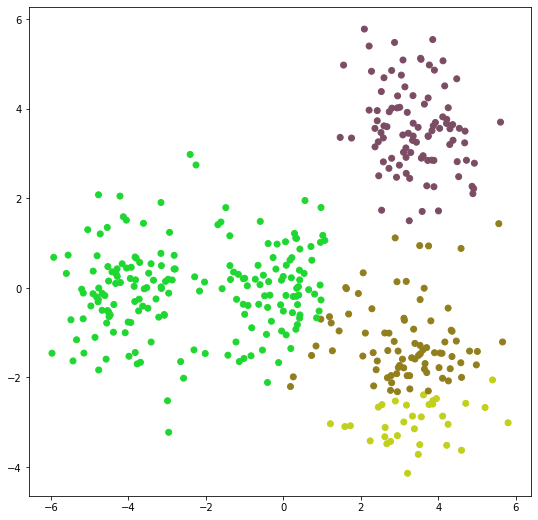

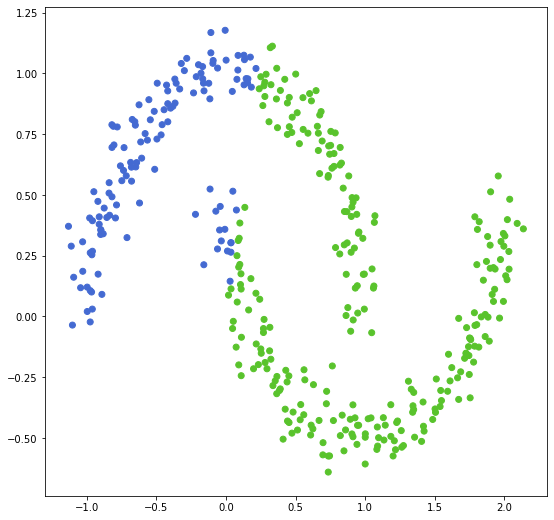

In [50]:
kmeans = KMeans(n_clusters=4, init='sample')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init='sample')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### K-Means++ Init

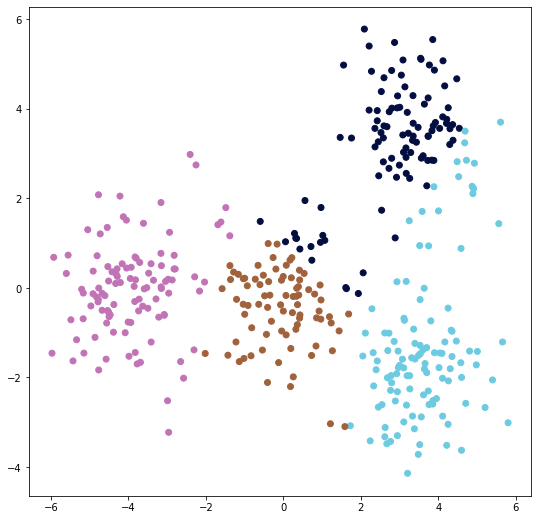

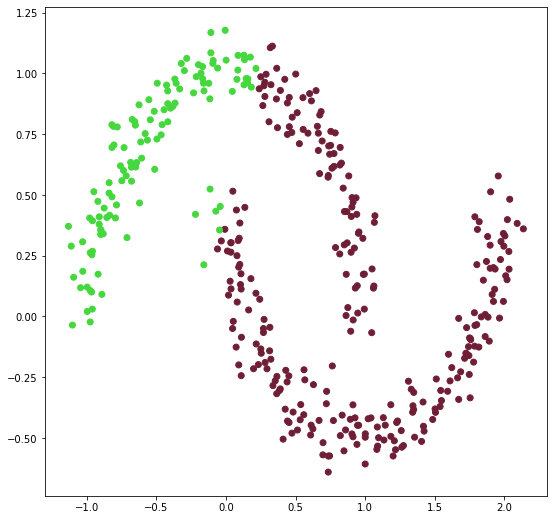

In [55]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Наблюдения
Видно, что в зависимости от инициализации, результаты кластеризации на `blob` разные,

а именно `random` $\le\le$ `sample` $\le\le$ `k-means++`

На `moon` все виды инициализации ведут себя примерно одинаково

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [ ]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        raise NotImplementedError()
        
    def fit_predict(self, X, y=None):
        raise NotImplementedError()

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [ ]:
dbscan = DBScan()
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan()
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [ ]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        raise NotImplementedError()
    
    def fit_predict(self, X, y=None):
        raise NotImplementedError()


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [ ]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [ ]:
def read_image(path):
    raise NotImplementedError()

def show_image(image):
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image, path):
    raise NotImplementedError()

In [ ]:
show_image(read_image("./image.png"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [ ]:
def clusterize_image(image, **kwargs):
    cluster_colors = None # color of each cluster
    clusters = None # Cluster labels for each pixel in flattened image
    recolored = None # Image with pixel colors assigned to corresponding cluster colors
    
    clusters_statistics(image.reshape(-1, 3), cluster_colors, clusters) # Very slow (:
    return recolored

In [ ]:
image = read_image("./image.jpg")
result = clusterize_image(image)
show_image(result)
save_image(result, "result.jpg")